# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 : 김홍서
- 기수 : 11기



## 해당 과제에는 6개의 섹션과 7개의 문제가 있습니다! 누락없이 제출 부탁드립니다 :)

In [ ]:
!pip install wandb

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import가 안되어 직접 클래스 선언

import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from PIL import Image

"""
MetaData.csv를 나누어 만든 train, val, test 데이터프레임에 담긴 이미지와 레이블을 반환해주는 CustomImageDataset을 만들어주세요
참고자료 : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
"""

class CustomImageDataset(Dataset):

    def __init__(self, dataset_direc:str, df:pd.DataFrame, transform = None) -> None:

        # 3000개의 이미지를 담고있는 DataSet 디렉토리의 경로입니다.
        self.dataset_direc= "/content/drive/MyDrive/Colab Notebooks/DSL/DSL_assignments/CNN_HongSeoKim/DataSet/"

        self.df = df.reset_index(drop=True)

        self.to_tensor = ToTensor() # 파이토치에서는 모든 인풋을 torch.Tensor()로 바꿔줘야합니다.

        self.transform = transform

    # __init__() 함수에서 받은 데이터프레임에 포함된 전체 데이터포인트의 수를 반환하도록 해주세요
    def __len__(self) -> int :
        return len(self.df)


    def __getitem__(self, idx:int):
        # __init__() 함수에서 받은 데이터프레임의 각 행에서 받은 FileName, StrLabel, self.dataset_direc, Label을 이용해 이미지 데이터와 레이블을 반환해주세요

        path = path = os.path.join(self.dataset_direc, self.df.iloc[idx,1], self.df.iloc[idx,0])
        image = Image.open(path)
        label = self.df.iloc[idx,2]

        image = self.to_tensor(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

"""
[Batch, Channel, 224, 224]의 input을 받았을 때,
최종적으로 sigmoid activation function에 들어갈 값을 반환하는 ResBottleNeck, ResNet50 Class를 정의해주세요.
즉, 정의된 ResNet50의 output 값은 확률이 아니라 sigmoid에 들어가는 값이 됩니다.
"""

def conv3x3(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels=in_channels,
                    out_channels=out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)

def conv1x1(in_channels, out_channels, stride = 1):
    return nn.Conv2d(in_channels=in_channels,
                    out_channels=out_channels, kernel_size=1,
                    stride=stride, padding=0, bias=False)


class ResBottleNeck(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride=1, donwsample=None) -> None:
        super(ResBottleNeck, self).__init__()
        self.relu = nn.ReLU(inplace = True)
        # make the feature map size as half
        self.conv1 = conv1x1(in_channels, mid_channels, stride)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = conv3x3(mid_channels, mid_channels, stride=2)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = conv1x1(mid_channels, out_channels, stride)

        self.donwsample = donwsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)

        if self.donwsample is not None:
            identity = self.donwsample(x)

        out += identity
        out = self.relu(out)
        return out


class ResNet50(nn.Module):
    def __init__(self) -> None:
        super(ResNet50,self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7,
                          stride=2, padding=3, bias=True),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace = True),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )

        self.conv21 = ResBottleNeck(in_channels = 64, mid_channels=64, out_channels=256,
                                  stride=1, donwsample=conv1x1(in_channels=64, out_channels=256))
        self.conv22 = ResBottleNeck(in_channels = 256, mid_channels=64, out_channels=256,
                            stride=1, donwsample=None)
        self.conv23 = ResBottleNeck(in_channels = 256, mid_channels=64, out_channels=256,
                            stride=1, donwsample=None)

        self.conv31 = ResBottleNeck(in_channels = 256, mid_channels=128, out_channels=512,
                            stride=1, donwsample=conv1x1(in_channels=256, out_channels=512, stride = 2))
        self.conv32 = ResBottleNeck(in_channels = 512, mid_channels=128, out_channels=512,
                            stride=1, donwsample=None)
        self.conv33 = ResBottleNeck(in_channels = 512, mid_channels=128, out_channels=512,
                            stride=1, donwsample=None)
        self.conv34 = ResBottleNeck(in_channels = 512, mid_channels=128, out_channels=512,
                            stride=1, donwsample=None)

        self.conv41 = ResBottleNeck(in_channels = 512, mid_channels=256, out_channels=1024,
                            stride=1, donwsample=conv1x1(in_channels=512, out_channels=1024, stride = 2))
        self.conv42 = ResBottleNeck(in_channels = 1024, mid_channels=256, out_channels=1024,
                            stride=1, donwsample=None)
        self.conv43 = ResBottleNeck(in_channels = 1024, mid_channels=256, out_channels=1024,
                            stride=1, donwsample=None)
        self.conv44 = ResBottleNeck(in_channels = 1024, mid_channels=256, out_channels=1024,
                            stride=1, donwsample=None)
        self.conv45 = ResBottleNeck(in_channels = 1024, mid_channels=256, out_channels=1024,
                            stride=1, donwsample=None)
        self.conv46 = ResBottleNeck(in_channels = 1024, mid_channels=256, out_channels=1024,
                            stride=1, donwsample=None)

        self.conv51 = ResBottleNeck(in_channels = 1024, mid_channels=512, out_channels=2048,
                            stride=1, donwsample=conv1x1(in_channels=1024, out_channels=2048, stride = 2))
        self.conv52 = ResBottleNeck(in_channels = 2048, mid_channels=512, out_channels=2048,
                            stride=1, donwsample=None)
        self.conv53 = ResBottleNeck(in_channels = 2048, mid_channels=512, out_channels=2048,
                            stride=1, donwsample=None)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(2048, 1)

    def forward(self,x):

        #########################
        #  Froward Propagation  #
        #########################
        out = self.conv1(x)
        out = self.conv21(out)
        out = self.conv22(out)
        out = self.conv23(out)

        out = self.conv31(out)
        out = self.conv32(out)
        out = self.conv33(out)
        out = self.conv34(out)

        out = self.conv41(out)
        out = self.conv42(out)
        out = self.conv43(out)
        out = self.conv44(out)
        out = self.conv45(out)
        out = self.conv46(out)

        out = self.conv51(out)
        out = self.conv52(out)
        out = self.conv53(out)

        out = self.avgpool(out).squeeze(dim = -1).squeeze(dim = -1)
        out = self.fc(out).squeeze(dim = -1)

        return out

In [ ]:
import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import tqdm

In [ ]:
# config.yaml의 위치를 지정해주세요
config_path = "/content/drive/MyDrive/Colab Notebooks/DSL/DSL_assignments/CNN_HongSeoKim/scripts/config.yaml"

# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [ ]:
# config.yaml에서 디렉토리, 모델 하이퍼파라미터를 각각 받아옵니다
import yaml
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

dataset_direc, meta_direc, weight_direc \
    = config["Direc"]["DatasetDirec"], \
      config["Direc"]["MetaDataDirec"], \
      config["Direc"]["WeightDirec"]

epoch, batch_size, lr \
    = config["HyperParameters"]["Epoch"], \
      config["HyperParameters"]["BatchSize"], \
      float(config["HyperParameters"]["LearningRate"]) # config.yaml에서 이미 float 자료형으로 학습률을 정의하신 분은 float()으로 자료형 변환을 하지 않으셔도 됩니다.

In [ ]:
import wandb # wandb.ai으로의 실시간 연동을 위한 라이브러리 임포트
from signal import signal, SIGPIPE, SIG_DFL
#Ignore SIG_PIPE and don't throw exceptions on it... (http://docs.python.org/library/signal.html)
signal(SIGPIPE,SIG_DFL)

# wandb login
wandb.init(
    project="DSL_ResNet", entity='hongseo-kim',
    name='hongseo-kim-cnn-augmentation',
    config={
        "model_name": f"hongseo-kim-cnn-augmentation",
        "epochs": epoch,
        "batch_size": batch_size,
        "lr": lr
    })

config = wandb.config

In [ ]:
# 가속을 위해 device로 GPU로 설정해줍니다
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. train, val, test DataLoader 초기화

### 문제 1.

모델의 학습을 train, validation, test로 나눠서 진행하는 이유는 무엇인가요?
- (힌트 : 굳이 validation을 끼워넣는 이유는 무엇인가요?)
- => 모델이 실제 세계의 데이터에 대해 잘 일반화될 수 있는지 평가하고, 과적합(overfitting)을 방지하기 위함
### 문제 2.

모델의 generalization을 높여주기 위해 Augmentation을 사용할 수 있다고 했습니다.

PyTorch 구현상으로는 train, validation, test 모든 단계에 Augmention를 구현할 수 있습니다만, 실제로는 특정 단계에서만 Augmention를 수행하게 됩니다. 어느 단계에서 RandAugment가 적용되어야하는지와, 그 이유에 대해서 설명해주세요.
- => RandAugment는 주로 train set에 적용됨. RandAugment를 사용하는 이유는 모델이 보다 다양한 형태의 데이터를 경험하게 하여, 실제 세계에서 발생할 수 있는 다양한 변형에 대해 더 잘 대응할 수 있도록 함. 일반적으로, validation set과 Test set에는 augmentation을 적용하지 않음.이유는 모델의 성능을 평가할 때, 실제 서비스 환경이나 실제 데이터에 가까운 조건에서 모델을 평가하는 것이 중요하기 때문임. validation set의 경우, 데이터 변형 없이 원본 데이터의 성능을 평가하여 모델의 하이퍼파라미터를 조정하고, 과적합을 감지하는 데 초점을 맞춤.

### 문제 3.
CustomImageDataset과 DataLoader 클래스의 차이점에 대해서 설명해주세요.
- (힌트 : 두 클래스의 리턴 형식에 어떤 차이가 있나요? 어디서부터 Batch 단위로 리턴되나요?)
- CustomImageDataset는 이미지와 그에 해당하는 레이블을 리턴함. 반면, DataLoader은 batch 단위로 리턴함.

In [ ]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DSL/DSL_assignments/CNN_HongSeoKim/scripts/MetaData.csv")

# train : val : test = 6 : 2 : 2
train, val_test = train_test_split(meta_data, train_size=0.6, random_state=777)
val, test = train_test_split(val_test, train_size=0.5, random_state=777)

# Model generalization을 위해 RandomAugmentation에 어떤 변형을 가할 지 transforms.Compose([])로 묶어놓읍시다
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

])

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df=train, transform = train_transforms)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df=val, transform = None)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df=test, transform = None)


train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
train_dataset[0]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2153, 0.2515, 0.2881,  ..., 0.0000, 0.0000, 0.0000],
          [0.1942, 0.2153, 0.2251,  ..., 0.0000, 0.0000, 0.0000],
          [0.0910, 0.1192, 0.1482,  ..., 0.0000, 0.0000, 0.0000]]]),
 1)

# 3. 모델 초기화, 손실함수 및 optimizer 지정

### 문제 4.

주어진 과제는 Binary Classification 태스크입니다.

이중 분류를 위해서는 손실함수로 Binary Cross Entropy를 사용한다고 세션에서 배웠습니다.

PyTorch에는 Binary Cross Entropy를 학습에 사용할 수 있는 2가지 방법이 있는데요, 'nn.BCELoss'와 'nn.BCEWithLogitsLoss'입니다.

이 둘은 같아 보이지만 구현상에서 명백한 차이점이 있습니다.

이 둘의 차이점에 대해서 서술해주세요.

nn.BCEWithLogitsLoss는 nn.BCELoss와 유사하지만 로짓(logit) 값, 즉 시그모이드 활성화 함수를 적용하기 전의 값을 입력으로 받는다는 점이 다름. 그리하여, nn.BCELoss를 사용할 때는 모델의 출력층에 시그모이드 함수를 적용해야 함.특히, 로짓 값이 매우 크거나 작을 때 nn.BCEWithLogitsLoss가 더 안정적으로 기능함.

In [ ]:
# model을 선언하고 GPU에 올려줍니다
model = ResNet50()
model.to(device)

In [ ]:
# 손실함수를 정의해주세요
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer를 정의해주세요
optimizer = optim.Adam(model.parameters(), lr=lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

### 문제 5.
학습이 끝난 이후 val_loss, train_loss 변화 추이 그래프와 val_acc, train_acc 변화 추이 그래프를 첨부해주세요.
(wandb 대시보드에서 캡쳐하셔도 됩니다)

In [ ]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")


# Training, Validation 시작

for curr_epoch in tqdm.tqdm(range(epoch+1)): # iterate over all EPOCHS
  train_loss = 0
  correct_train = 0

  for img, label in (train_loader): # iterate over all BATCHES

    # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
    img, label = img.to(device), label.to(device)

    # Forward Propagation
    pred = model(img)

    # 손실함수 계산
    loss = criterion(pred, label.float()) # 구현상의 차이로 label 텐서에 조작을 가해 모양을 맞춰줘야하는 경우가 생길 수 있습니다 ( 힌트 : tensor.view() )

    # 누적된 기울기 초기화 및 역전파
    optimizer.zero_grad()
    loss.backward()

    # 파라미터 업데이트
    optimizer.step()

    # 해당 Batch에서의 loss를 train_loss 변수에 누적
    train_loss += loss.item()

    # Accuracy 계산
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    correct_train += (pred_class == label).float().sum()

  # 모든 Batch를 순회한 이후 최종적인 train_loss, train_acc를 계산해줍니다
  train_loss = train_loss/len(train_loader)
  train_acc = correct_train /len(train_loader.dataset)

  # Validation 시작
  model.eval()

  with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    val_loss = 0
    correct_val = 0

    for img, label in (val_loader): # iterate over all BATCHES

      ##################################
      # forward propagation, loss 구현  #
      ##################################

      val_loss += loss.item()

      # 모든 Batch를 순회한 이후 최종적인 val_loss, val_acc를 계산해줍니다
      img, label = img.to(device), label.to(device)
      pred = model(img)
      pred_class = (torch.sigmoid(pred) > 0.5).float()
      correct_val += (pred_class == label).float().sum()

    val_loss /= len(val_loader)
    val_acc = correct_val / len(val_loader)

  # wandb.ai에 보낼 log 데이터를 작성해줍니다.
  metrics = {
    "epoch": epoch,
    "train_loss": train_loss,
    "val_loss" : val_loss,
    "train_acc": train_acc.item(),
    "val_acc" : val_acc.item(),
    "learning_rate": lr
    }

  # 아래 코드를 통해 실시간으로 학습현황을 확인할 수 있도록 log 데이터를 전송해줍니다
  wandb.log(metrics)

  # 모델을 다시 학습모드로 설정합니다
  model.train()

  # 가장 작은 validation loss를 가졌을 때의 모델 파라미터를 저장해줍니다.
  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt")) # .pt 확장자로 저장해주도록합니다

wandb.finish()

100%|██████████| 41/41 [35:54<00:00, 52.54s/it]


<center>
<img src='https://drive.google.com/uc?id=1z3ajvTiYKl_ItAjY31cDHHMuRGcESJoL'/><br>
</center>

# 5. Test

학습이 모두 끝났다면, 가장 낮은 validation loss를 기록한 모델의 파라미터를 불러오도록합시다.

이후에는 confusion matrix, accuracy 등을 측정하여 모델이 얼마나 잘 학습되었는지 평가하도록 하겠습니다.

### 문제6.

accuracy 95% 이상이 되도록 학습률 등을 조절해주세요.

In [ ]:
trained_model = ResNet50() # 우선 ResNet50 모델 하나를 초기화 해줍니다
trained_model.load_state_dict(torch.load(os.path.join(weight_direc, "best_model(aug).pt"))) # 아까 저장해둔 weight를 로드해줍니다
trained_model.eval() # 모델을 evaluation 모드로 설정합니다
trained_model.to(device)

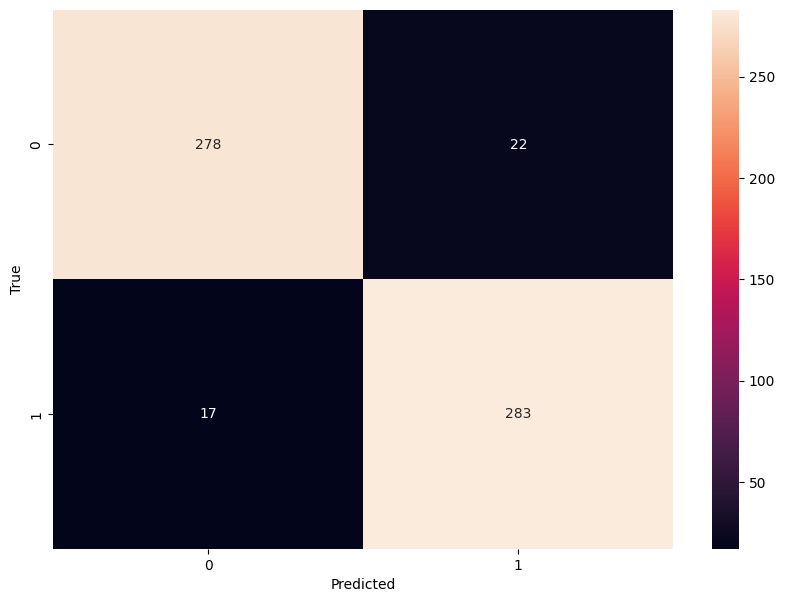

Accuracy: 93.50%


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

all_labels = []
all_predictions = []

for image, label in (test_loader):
  image, label = image.to(device), label.to(device)

  with torch.no_grad(): # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    pred = model(image) # 순전파

    probabilities = torch.sigmoid(pred) # 시그모이드 함수를 이용해 확률을 계산합니다
    predicted = (probabilities > 0.5).float()  # 확률을 label로 바꿔줍니다

    all_labels.extend(label.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix를 그려줍니다
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy도 출력해봅시다
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# 6. Augmentation vs No Augmentation

### 문제 7.

전달받으신 파일들 중, Run_NoAugment.ipynb라는 파일이 있을 겁니다.

지금 보고 계신 노트북과 똑같이 학습을 시키시되, 이번에는 학습 시 data augmentation을 적용시키지 않고 진행하십시오.

이후 augmentation을 적용시키지 않은 모델의 train loss와 val loss의 차트를 아래에 붙여놓으시고,

augmentation을 적용한 모델의 학습 양상과 어떤 점이 다른 지와 그 이유도 함께 설명해주세요.

<center>
<img src='https://drive.google.com/uc?id=15L83phEUHeUNEUoJVNUvryX_VrB7ACth'/><br>
</center>

- train data의 경우에 데이터의 다양성이 증가하여, augmentation을 하지 않은 경우에 train loss가 비교적 낮은 수준에서 시작하는 것을 알 수 있음. 또한, 과적합의 문제가 발생할 수 있음.